* import libraries

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from glob import glob

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

This Jupiter Notebook provides some useful preprocesing steps for dicom data. 

For this Tutorial I use the COVID-19 CT Scans Dataset.



### Loading the DICOM files and adding missing metadata


In [2]:
# Some constants 
INPUT_FOLDER = '/COVID/covid19-ct-scans/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
OUTPUT_PATH = '/COVID/Output_Covid/'



# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images.\nFilenames: " % len(patients))
print ('\n'.join(patients))

Total of 10 DICOM images.
Filenames: 
Case_001
Case_002
Case_003
Case_004
Case_005
Case_006
Case_007
Case_008
Case_009
Case_010


### Load scans in given folder path

In [3]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
     
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

### Converting the pixel values to Hounsfield Units (HU), and what tissue these unit values correspond to


In [4]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


Let's take a look at one of the patients.

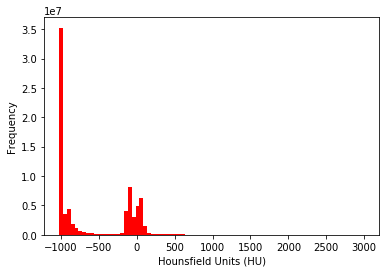

In [5]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='r')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

### Visualize some slices

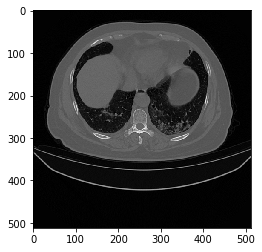

In [67]:
plt.imshow(first_patient_pixels[200], cmap=plt.cm.gray)
plt.show()


In [69]:
id=0
patient = load_scan(INPUT_FOLDER + patients[id])
imgs = get_pixels_hu(patient)

np.save(OUTPUT_PATH + "images_%d.npy" % (id), imgs)

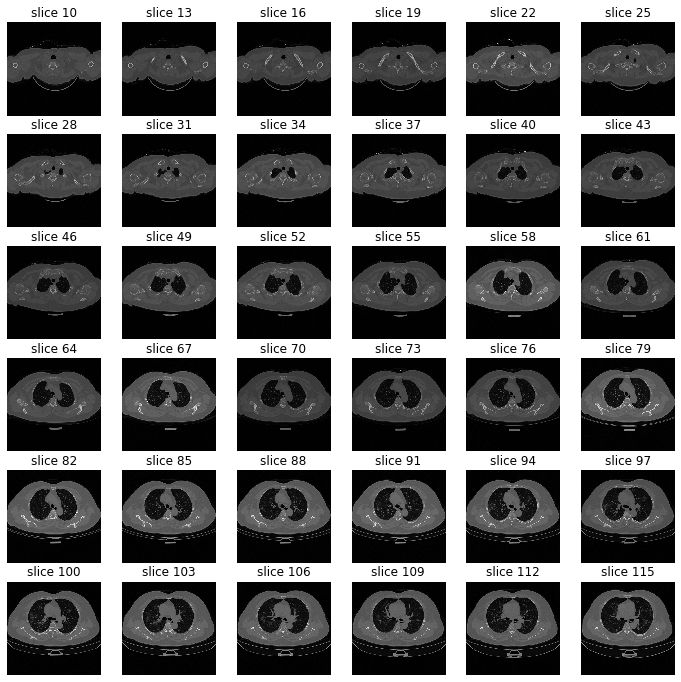

In [70]:
id = 0
imgs_to_process = np.load(OUTPUT_PATH+'images_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)


### Resampling to an isomorphic resolution to remove variance in scanner resolution.


In [71]:
print ("Slice Thickness: %f" % patient[0].SliceThickness)
print ("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 1.000000
Pixel Spacing (row, col): (0.810547, 0.810547) 


In [72]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [73]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (301, 512, 512)
Shape after resampling	 (301, 415, 415)


### 3D plotting and lung visualization 


In [74]:
def plot_3d(image, threshold=-300):
    
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.1)
 
    face_color = [0, 0, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [ ]:
plot_3d(pix_resampled, 500)

### Lung segmentation


In [53]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    
    background_label = labels[0,0,0]
    
   
    binary_image[background_label == labels] = 2
    
    
   
    if fill_lung_structures:
        
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)           
            if l_max is not None: 
                binary_image[i][labeling != l_max] = 1
    
    binary_image -= 1 
    binary_image = 1-binary_image 
   
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None:
        binary_image[labels != l_max] = 0
 
    return binary_image

In [54]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

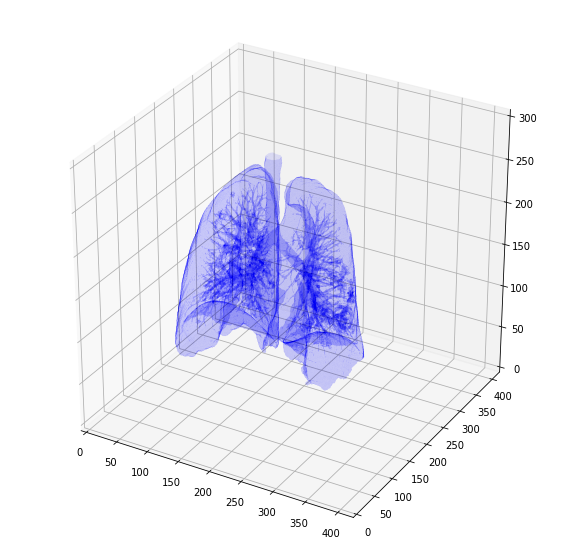

In [20]:
plot_3d(segmented_lungs, 0)

But there's one thing we can fix, it is probably a good idea to include structures within the lung (as the nodules are solid), we do not only want to air in the lungs.

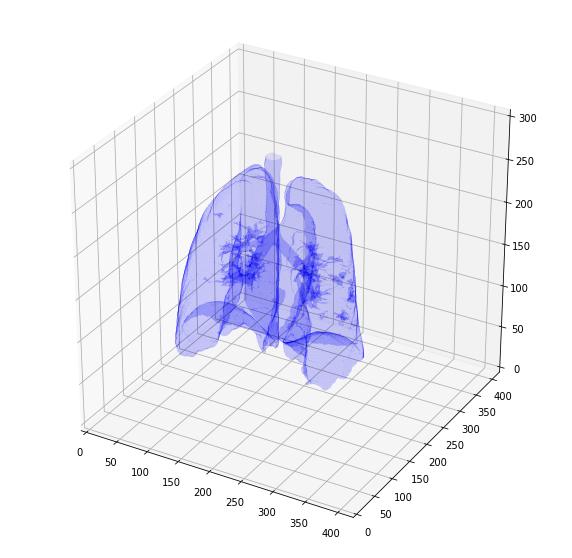

In [21]:
plot_3d(segmented_lungs_fill, 0)

Let's also visualize the difference between the two.

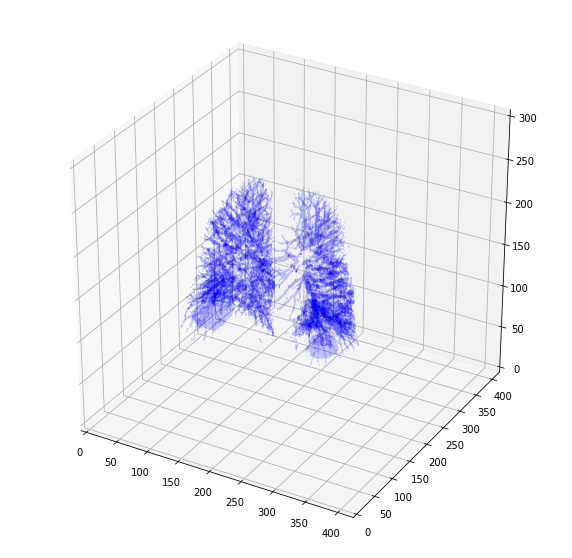

In [22]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

### Normalization


In [55]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [56]:
normalize(segmented_lungs_fill)


### Zero centering


In [57]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image


In [58]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
normalized_lungs_image = normalize(segmented_lungs_fill)
zero_center_lungs_images = zero_center(normalized_lungs_image)

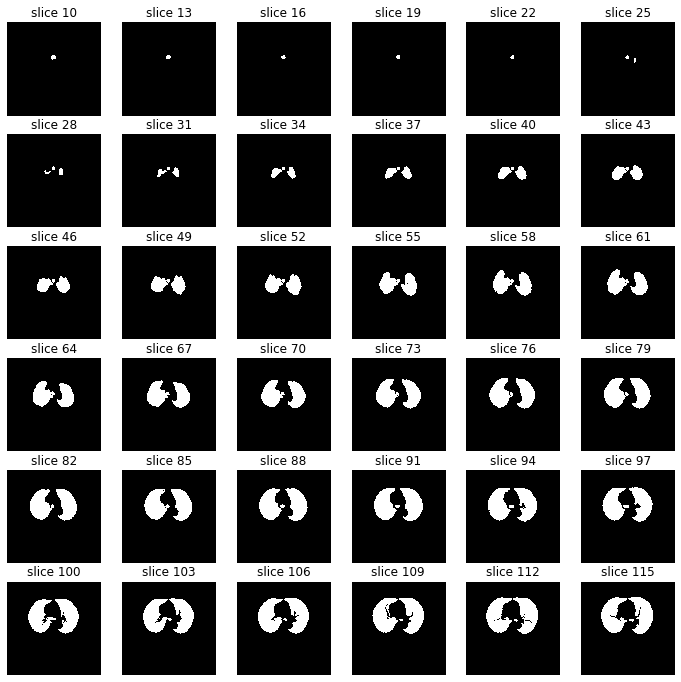

In [59]:
sample_stack(zero_center_lungs_images)

In [30]:
for id in range(0, 10):
    patient = load_scan(INPUT_FOLDER + patients[id])
    patient_pixels = get_pixels_hu(patient)
    pix_resampled, spacing = resample(patient_pixels, first_patient, [1,1,1])
    segmented_lungs = segment_lung_mask(pix_resampled, False)
    segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
    normalized_lungs_image = normalize(segmented_lungs_fill)
    zero_center_lungs_images = zero_center(normalized_lungs_image)
    np.save(OUTPUT_PATH + "maskedimages_%d.npy" % (id), zero_center_lungs_images)

In [ ]:
imgs_to_process = np.load(OUTPUT_PATH+'maskedimages_1.npy')
sample_stack(imgs_to_process)

In [ ]:
imgs_to_process = np.load(OUTPUT_PATH+'maskedimages_2.npy')
sample_stack(imgs_to_process)